In [1]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Using GPU: ", tf.test.gpu_device_name())


Num GPUs Available:  1
Using GPU:  /device:GPU:0


In [ ]:
!apt-get install unrar

from google.colab import files

uploaded = files.upload() 


!mkdir /content/runs_extracted
!unrar x /content/runs.rar /content/runs_extracted/


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Saving runs.rar to runs.rar

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/runs.rar

Creating    /content/runs_extracted/runs                              OK
Creating    /content/runs_extracted/runs/detect                       OK
Creating    /content/runs_extracted/runs/detect/train                 OK
Extracting  /content/runs_extracted/runs/detect/train/args.yaml            0%  OK 
Creating    /content/runs_extracted/runs/detect/train2                OK
Extracting  /content/runs_extracted/runs/detect/train2/args.yaml           0%  OK 
Extracting  /content/runs_extracted/runs/detect/train2/BoxF1_curve.png       0%  OK 
Extracting  /content/runs_extracted/runs/detect/train2/BoxPR_curve.png       0%  OK 
Extracting  /content/runs_extracted/runs/detect/train2/BoxP_curve.png       1%  OK 
Extracting  /content/runs_extracted/runs/detect/train2/BoxR_curve.png       1%  OK 
Extracting 

In [3]:
!pip install ultralytics tensorflow opencv-python matplotlib scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00



image 1/1 /content/100_p2.jpeg: 480x640 1 Taka, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


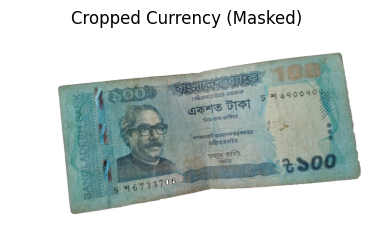

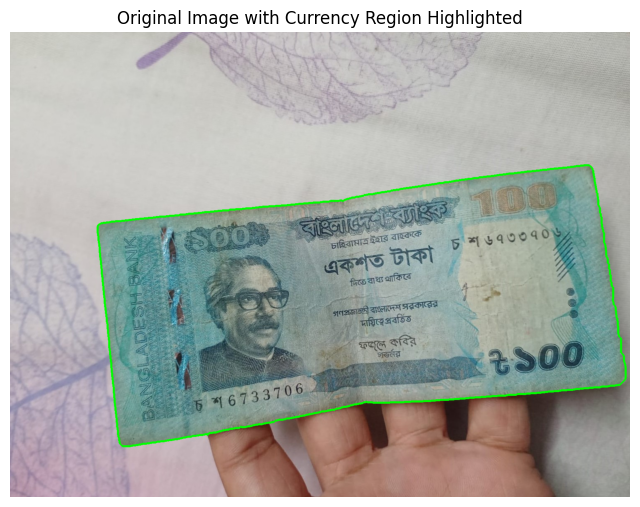

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os


# Load YOLO model

model = YOLO("/content/runs_extracted/runs/detect/train2/weights/best.pt") 


# Run YOLO detection

image_path = "/content/100_p2.jpeg"  
results = model(image_path)

orig_img = cv2.imread(image_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  

overlay_img = orig_img.copy()


# Process detections

mask_id = 0


#Expand bounding box

def expand_bbox(x1, y1, x2, y2, img_shape, scale=0.15):
    """
    Expand bounding box by scale factor.
    """
    h, w = img_shape[:2]
    dx = int((x2 - x1) * scale)
    dy = int((y2 - y1) * scale)

    new_x1 = max(0, x1 - dx)
    new_y1 = max(0, y1 - dy)
    new_x2 = min(w, x2 + dx)
    new_y2 = min(h, y2 + dy)

    return new_x1, new_y1, new_x2, new_y2



for r in results:
    boxes = r.boxes.xyxy.cpu().numpy().astype(int)

    for (x1, y1, x2, y2) in boxes:
        # Crop ROI
        
        x1, y1, x2, y2 = expand_bbox(x1, y1, x2, y2, orig_img.shape, scale=0.15)
      
        crop = orig_img[y1:y2, x1:x2]

       
        # GrabCut for currency shape segmentation
        
        mask = np.zeros(crop.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        rect = (1, 1, crop.shape[1]-2, crop.shape[0]-2)  
        cv2.grabCut(crop, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
       
        white_bg = np.ones_like(crop, dtype=np.uint8) * 255  

        # Paste currency on white background
        currency_shape = white_bg.copy()
        currency_shape[mask2 == 1] = crop[mask2 == 1]




       
        # Overlay mask on original image
        
        contour, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contour) > 0:
            contour = max(contour, key=cv2.contourArea)
            contour_shifted = contour + [x1, y1]
            cv2.drawContours(overlay_img, [contour_shifted], -1, (0,255,0), 3)

       
        cv2.imwrite(f"/content/currency_mask_{mask_id}.png", mask2*255)
        cv2.imwrite(f"/content/currency_region_{mask_id}.png", cv2.cvtColor(currency_shape, cv2.COLOR_RGB2BGR))
        mask_id += 1

        
        # Show cropped region
        
        plt.figure(figsize=(10,8))
        plt.subplot(1,2,1)
        plt.title("Cropped Currency (Masked)")
        plt.imshow(currency_shape)
        plt.axis("off")




# Show original image with overlay

plt.figure(figsize=(8,8))
plt.title("Original Image with Currency Region Highlighted")
plt.imshow(overlay_img)
plt.axis("off")
plt.show()
